In [4]:
# %% TASK 4: Time-series forecasting with simple regression network
# Older time steps are treated as additional features

# author: Ribana Roscher

import numpy
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# %% helper functions =======================================================
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

# %% dataset preprocessing (do not change)
# load tide gauge data [year month day hour minute height]
data = pandas.read_csv("pellworm_data.csv", header=None)
dataset = data.values
dataset = dataset.astype('float32')

# choose output data (use only every nth (stepsize) data sample)
D = dataset.shape[1]
N = 10000;
stepsize = 20;
Y = dataset[0:N:stepsize,D-1]

# choose input data: convert time data into index vector
dates = dataset[0:N:stepsize,0:D-1]
X = numpy.array(range(0, Y.shape[0]))
X = X.astype('float32')

# scale data to range (0, 1)
X_min = X.min()
X = X - X_min
X_max = X.max()
X = X / X_max
Y_min = Y.min()
Y = Y - Y_min
Y_max = Y.max()
Y = Y / Y_max

# split train/test data
train_size = int(len(Y) * 0.67)
test_size = len(Y) - train_size
train, test = Y[0:train_size], Y[train_size:len(Y)]

# reshape into X=(t:t-look_back) [input] and Y=t+1 [output]
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
#Exercise 4

Epoch 1/100
314/314 [==============================] - 0s 422us/step - loss: 0.0612
Epoch 2/100
314/314 [==============================] - 0s 185us/step - loss: 0.0074
Epoch 3/100
314/314 [==============================] - 0s 164us/step - loss: 0.0032
Epoch 4/100
314/314 [==============================] - 0s 179us/step - loss: 0.0022
Epoch 5/100
314/314 [==============================] - 0s 177us/step - loss: 0.0019
Epoch 6/100
314/314 [==============================] - 0s 164us/step - loss: 0.0014
Epoch 7/100
314/314 [==============================] - 0s 173us/step - loss: 0.0012
Epoch 8/100
314/314 [==============================] - 0s 180us/step - loss: 0.0012
Epoch 9/100
314/314 [==============================] - 0s 161us/step - loss: 9.3763e-04
Epoch 10/100
314/314 [==============================] - 0s 156us/step - loss: 8.4723e-04
Epoch 11/100
314/314 [==============================] - 0s 152us/step - loss: 9.0506e-04
Epoch 12/100
314/314 [==============================] - 0s 154

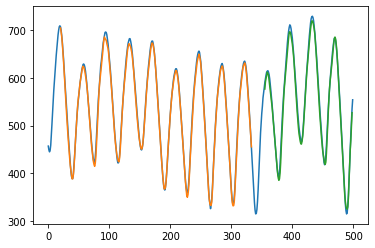

In [5]:
# %% baseline model ==========================================================
model = Sequential()
#ADD HERE A DENSE LAYER WITH 32 NEURONS AND INPUT SHAPE OF look_back AND A RELU
#ACTIVATION FUNCTION
model.add(Dense(units=32, input_dim=look_back, activation='relu'))
model.add(Dense(1, input_dim=look_back, activation='linear'))

# ADD HERE FURTHER LAYERS AND CHANGE THE PREVIOUS ONE
model.compile(loss='mean_squared_error', optimizer='adam')

# run baseline model
model.fit(trainX, trainY, epochs=100, batch_size=5)
testPredict = model.predict(testX)
trainPredict = model.predict(trainX)

# rescale and plot result
trainX = (trainX * X_max) + X_min
testX = (testX * X_max) + X_min
trainY = (trainY * Y_max) + Y_min           
testY = (testY * Y_max) + Y_min
Y = (Y * Y_max) + Y_min
trainPredict = (trainPredict * Y_max) + Y_min  
testPredict = (testPredict * Y_max) + Y_min     

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('RMSE (train data): %.2f [cm]' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('RMSE (test data): %.2f [cm]' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Y)
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0] # study syntex
                
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(Y)
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(Y)-1] = testPredict[:,0]
               
# plot baseline and predictions
plt.plot(Y)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Exercise 5

In [4]:
# %% TASK 5: Time-series forecasting with LSTM
# Older time steps are treated as additional features

# author: Ribana Roscher

import numpy
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# %% helper functions =======================================================
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

# %% dataset preprocessing (do not change)
# load tide gauge data [year month day hour minute height]
data = pandas.read_csv("pellworm_data.csv", header=None)
dataset = data.values
dataset = dataset.astype('float32')

# choose output data (use only every nth (stepsize) data sample)
D = dataset.shape[1]
N = 10000; #try with small sample size if it can overfit
#N = 20000;
stepsize = 20;
Y = dataset[0:N:stepsize,D-1]

# choose input data: convert time data into index vector
dates = dataset[0:N:stepsize,0:D-1]
X = numpy.array(range(0, Y.shape[0]))
X = X.astype('float32')

# scale data to range (0, 1)
X_min = X.min()
X = X - X_min
X_max = X.max()
X = X / X_max
Y_min = Y.min()
Y = Y - Y_min
Y_max = Y.max()
Y = Y / Y_max

# split train/test data
train_size = int(len(Y) * 0.67)
test_size = len(Y) - train_size
train, test = Y[0:train_size], Y[train_size:len(Y)]

# reshape into X=(t:t-look_back) [input] and Y=t+1 [output]
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(dataset.shape)
print(X.shape)
print(trainX.shape)
print(testX.shape)
print(Y.shape)
print(trainY.shape)
#Y.shape

(1048516, 6)
(1000,)
(649, 20)
(309, 20)
(1000,)
(649,)


Epoch 1/100
324/324 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 2/100
324/324 [==============================] - 0s 310us/step - loss: 0.0209
Epoch 3/100
324/324 [==============================] - 0s 282us/step - loss: 0.0111
Epoch 4/100
324/324 [==============================] - 0s 319us/step - loss: 0.0039
Epoch 5/100
324/324 [==============================] - 0s 311us/step - loss: 0.0014
Epoch 6/100
324/324 [==============================] - 0s 313us/step - loss: 0.0011
Epoch 7/100
324/324 [==============================] - 0s 302us/step - loss: 0.0011
Epoch 8/100
324/324 [==============================] - 0s 311us/step - loss: 0.0010
Epoch 9/100
324/324 [==============================] - 0s 314us/step - loss: 0.0010
Epoch 10/100
324/324 [==============================] - 0s 353us/step - loss: 9.9232e-04
Epoch 11/100
324/324 [==============================] - 0s 309us/step - loss: 9.4861e-04
Epoch 12/100
324/324 [==============================] - 0s 318us/ste

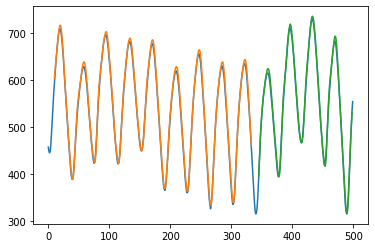

In [22]:
# %% LSTM network
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
#ADD HERE AN LSTM LAYER WITH 32 NEURONS AND INPUT SHAPE OF (1, look_back)
model.add(LSTM(units=32, input_shape=(1,look_back)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainX = (trainX * X_max) + X_min
testX = (testX * X_max) + X_min
trainY = (trainY * Y_max) + Y_min           
testY = (testY * Y_max) + Y_min
Y = (Y * Y_max) + Y_min
trainPredict = (trainPredict * Y_max) + Y_min  
testPredict = (testPredict * Y_max) + Y_min

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('RMSE: %.2f [cm]' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('RMSE: %.2f [cm]' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Y)
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
                
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(Y)
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(Y)-1] = testPredict[:,0]
               
# plot baseline and predictions
plt.plot(Y)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
#look_back=20, N = 5000: 
##RMSE: 5.21 [cm]
##RMSE: 11.62 [cm]
#look_back=20, N = 10000: 
##RMSE: 4.90 [cm]
##RMSE: 7.22 [cm]

#look_back=10, N = 10000: 
RMSE: 6.72 [cm]
RMSE: 6.39 [cm]

In [70]:
#Exercise 6

Train on 180 samples, validate on 20 samples
Epoch 1/380
180/180 [==============================] - 3s 16ms/step - loss: 3.2570 - accuracy: 0.0500 - val_loss: 3.2546 - val_accuracy: 0.0500
Epoch 2/380
180/180 [==============================] - 0s 1ms/step - loss: 3.2497 - accuracy: 0.0667 - val_loss: 3.2524 - val_accuracy: 0.1000
Epoch 3/380
180/180 [==============================] - 0s 1ms/step - loss: 3.2401 - accuracy: 0.0722 - val_loss: 3.2463 - val_accuracy: 0.1000
Epoch 4/380
180/180 [==============================] - 0s 1ms/step - loss: 3.2202 - accuracy: 0.0722 - val_loss: 3.2390 - val_accuracy: 0.1000
Epoch 5/380
180/180 [==============================] - 0s 1ms/step - loss: 3.1907 - accuracy: 0.0722 - val_loss: 3.2707 - val_accuracy: 0.1000
Epoch 6/380
180/180 [==============================] - 0s 1ms/step - loss: 3.1753 - accuracy: 0.0722 - val_loss: 3.2849 - val_accuracy: 0.1000
Epoch 7/380
180/180 [==============================] - 0s 1ms/step - loss: 3.1652 - accuracy: 0.

Epoch 57/380
180/180 [==============================] - 0s 900us/step - loss: 1.8111 - accuracy: 0.4111 - val_loss: 2.0763 - val_accuracy: 0.3500
Epoch 58/380
180/180 [==============================] - 0s 915us/step - loss: 1.7609 - accuracy: 0.4444 - val_loss: 2.0438 - val_accuracy: 0.3500
Epoch 59/380
180/180 [==============================] - 0s 910us/step - loss: 1.7340 - accuracy: 0.4556 - val_loss: 2.0003 - val_accuracy: 0.4000
Epoch 60/380
180/180 [==============================] - 0s 888us/step - loss: 1.7310 - accuracy: 0.4722 - val_loss: 2.0006 - val_accuracy: 0.4000
Epoch 61/380
180/180 [==============================] - 0s 892us/step - loss: 1.7085 - accuracy: 0.4889 - val_loss: 1.9620 - val_accuracy: 0.4500
Epoch 62/380
180/180 [==============================] - 0s 878us/step - loss: 1.6950 - accuracy: 0.4889 - val_loss: 1.9340 - val_accuracy: 0.4500
Epoch 63/380
180/180 [==============================] - 0s 880us/step - loss: 1.6671 - accuracy: 0.5056 - val_loss: 1.9252 -

180/180 [==============================] - 0s 1ms/step - loss: 1.1145 - accuracy: 0.6889 - val_loss: 1.4188 - val_accuracy: 0.5500
Epoch 114/380
180/180 [==============================] - 0s 1ms/step - loss: 1.1005 - accuracy: 0.6889 - val_loss: 1.3878 - val_accuracy: 0.6000
Epoch 115/380
180/180 [==============================] - 0s 1ms/step - loss: 1.0906 - accuracy: 0.6722 - val_loss: 1.3675 - val_accuracy: 0.6500
Epoch 116/380
180/180 [==============================] - 0s 940us/step - loss: 1.0829 - accuracy: 0.6833 - val_loss: 1.3780 - val_accuracy: 0.6000
Epoch 117/380
180/180 [==============================] - 0s 977us/step - loss: 1.0788 - accuracy: 0.7056 - val_loss: 1.3770 - val_accuracy: 0.6000
Epoch 118/380
180/180 [==============================] - 0s 940us/step - loss: 1.0709 - accuracy: 0.6944 - val_loss: 1.3749 - val_accuracy: 0.6000
Epoch 119/380
180/180 [==============================] - 0s 947us/step - loss: 1.0645 - accuracy: 0.6722 - val_loss: 1.3698 - val_accuracy

Epoch 169/380
180/180 [==============================] - 0s 847us/step - loss: 0.7921 - accuracy: 0.7500 - val_loss: 1.1712 - val_accuracy: 0.7000
Epoch 170/380
180/180 [==============================] - 0s 858us/step - loss: 0.7929 - accuracy: 0.7556 - val_loss: 1.1732 - val_accuracy: 0.7000
Epoch 171/380
180/180 [==============================] - 0s 847us/step - loss: 0.7899 - accuracy: 0.7500 - val_loss: 1.1609 - val_accuracy: 0.7000
Epoch 172/380
180/180 [==============================] - 0s 859us/step - loss: 0.7807 - accuracy: 0.7389 - val_loss: 1.1960 - val_accuracy: 0.7000
Epoch 173/380
180/180 [==============================] - 0s 845us/step - loss: 0.7766 - accuracy: 0.7556 - val_loss: 1.1618 - val_accuracy: 0.6500
Epoch 174/380
180/180 [==============================] - 0s 835us/step - loss: 0.7776 - accuracy: 0.7444 - val_loss: 1.1860 - val_accuracy: 0.6500
Epoch 175/380
180/180 [==============================] - 0s 850us/step - loss: 0.7730 - accuracy: 0.7556 - val_loss: 1

Epoch 225/380
180/180 [==============================] - 0s 847us/step - loss: 0.7550 - accuracy: 0.7389 - val_loss: 1.1018 - val_accuracy: 0.7000
Epoch 226/380
180/180 [==============================] - 0s 843us/step - loss: 0.7111 - accuracy: 0.7833 - val_loss: 1.0627 - val_accuracy: 0.7000
Epoch 227/380
180/180 [==============================] - 0s 846us/step - loss: 0.8079 - accuracy: 0.6889 - val_loss: 1.0287 - val_accuracy: 0.7500
Epoch 228/380
180/180 [==============================] - 0s 851us/step - loss: 0.7312 - accuracy: 0.7278 - val_loss: 1.2323 - val_accuracy: 0.6500
Epoch 229/380
180/180 [==============================] - 0s 846us/step - loss: 0.7511 - accuracy: 0.7389 - val_loss: 1.0994 - val_accuracy: 0.7000
Epoch 230/380
180/180 [==============================] - 0s 858us/step - loss: 0.8151 - accuracy: 0.7444 - val_loss: 1.1335 - val_accuracy: 0.6500
Epoch 231/380
180/180 [==============================] - 0s 837us/step - loss: 0.6985 - accuracy: 0.7778 - val_loss: 1

Epoch 281/380
180/180 [==============================] - 0s 924us/step - loss: 0.4508 - accuracy: 0.9222 - val_loss: 0.9350 - val_accuracy: 0.7500
Epoch 282/380
180/180 [==============================] - 0s 862us/step - loss: 0.4499 - accuracy: 0.9167 - val_loss: 0.9353 - val_accuracy: 0.7500
Epoch 283/380
180/180 [==============================] - 0s 838us/step - loss: 0.4545 - accuracy: 0.9111 - val_loss: 0.9311 - val_accuracy: 0.7500
Epoch 284/380
180/180 [==============================] - 0s 849us/step - loss: 0.4618 - accuracy: 0.8944 - val_loss: 0.9589 - val_accuracy: 0.7500
Epoch 285/380
180/180 [==============================] - 0s 854us/step - loss: 0.4810 - accuracy: 0.8722 - val_loss: 1.0191 - val_accuracy: 0.7000
Epoch 286/380
180/180 [==============================] - 0s 859us/step - loss: 0.5175 - accuracy: 0.8611 - val_loss: 0.9551 - val_accuracy: 0.7500
Epoch 287/380
180/180 [==============================] - 0s 847us/step - loss: 0.5070 - accuracy: 0.8611 - val_loss: 0

Epoch 337/380
180/180 [==============================] - 0s 858us/step - loss: 0.3631 - accuracy: 0.9278 - val_loss: 0.8899 - val_accuracy: 0.7500
Epoch 338/380
180/180 [==============================] - 0s 856us/step - loss: 0.3593 - accuracy: 0.9389 - val_loss: 0.8775 - val_accuracy: 0.7500
Epoch 339/380
180/180 [==============================] - 0s 864us/step - loss: 0.3510 - accuracy: 0.9667 - val_loss: 0.8751 - val_accuracy: 0.7500
Epoch 340/380
180/180 [==============================] - 0s 849us/step - loss: 0.3486 - accuracy: 0.9611 - val_loss: 0.8738 - val_accuracy: 0.7500
Epoch 341/380
180/180 [==============================] - 0s 877us/step - loss: 0.3503 - accuracy: 0.9389 - val_loss: 0.8792 - val_accuracy: 0.7500
Epoch 342/380
180/180 [==============================] - 0s 848us/step - loss: 0.3485 - accuracy: 0.9500 - val_loss: 0.8765 - val_accuracy: 0.7500
Epoch 343/380
180/180 [==============================] - 0s 849us/step - loss: 0.3441 - accuracy: 0.9500 - val_loss: 0

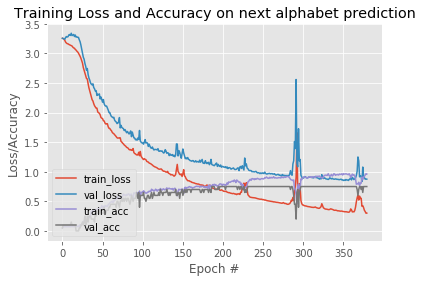

In [7]:
# %% TASK 6: Time-series forecasting with LSTM
# LSTM with Variable Length Input Sequences to One Character Output

import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

# %% dataset preprocessing (do not change)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# create mapping of characters to integers (0-25) and the reverse with dict hash table
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# prepare the dataset of input to output pairs encoded as integers
num_inputs = 200 # number of training samples (randomly generated)
max_len = 5 # maximum number of sequence length
dataX = []
dataY = []
for i in range(num_inputs):
	start = numpy.random.randint(len(alphabet)-2)
	end = numpy.random.randint(start, min(start+max_len,len(alphabet)-1))
	sequence_in = alphabet[start:end+1]
	sequence_out = alphabet[end + 1]
	dataX.append([char_to_int[char] for char in sequence_in])
	dataY.append(char_to_int[sequence_out])
    
# convert list of lists to array and pad sequences if needed (with zero)
X = pad_sequences(dataX, maxlen=max_len, dtype='float32')
# reshape X to be [samples, time steps, features]
X = numpy.reshape(X, (X.shape[0], max_len, 1))
# normalize by length of alphabet (26)
X = X / float(len(alphabet))
# one hot encode the output variabl
y = np_utils.to_categorical(dataY)
# %% create and fit the model
epochsVal = 380
learnRateVal = 0.001 # 
batchSizeVal = 16 # start with mini-batch size >5, <200?
opt = Adam(lr=learnRateVal, decay=learnRateVal / epochsVal)

# DEFINE A NETWORK WITH 1 OR MORE LSTM LAYER AND 1 DENSE LAYER
# HINT: LSTM(NUMBER OF UNITS, input_shape=(NUMBER OF TIMESTEPS, 1))
# HINT: IF YOU WANT TO ADD MULTIPLE LSTM LAYER, YOU NEED TO ADD return_sequences=True
# TO THE LSTM 
# HINT: THE OUTPUT OF THE DENSE LAYER SHOULD BE SOFTMAX AND THE NUMBER OF UNITS
# SHOULD RELATE TO THE NUMBER OF CLASSES
## create and fit the LSTM network
model = Sequential()
#model.add(LSTM(units=32, input_shape=(NUMBER OF TIMESTEPS, 1)))
for i in range(5):
    model.add(LSTM(units=32, input_shape=(5, 1),return_sequences=True))
#model.add(LSTM(units=32, input_shape=(5, 1),return_sequences=True)) #step of 5
#model.add(LSTM(units=20, input_shape=(5, 1),return_sequences=True))
#model.add(LSTM(units=20, input_shape=(5, 1),return_sequences=True))
model.add(LSTM(units=20, input_shape=(5, 1)))
model.add(Dense(26, activation='softmax')) #sigmoid: only for 0or1(binary); softmax for multi
##


model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
H = model.fit(X, y, epochs=epochsVal, batch_size=batchSizeVal, validation_split=0.1)

# %% summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model train accuracy: %.2f%%" % (scores[1]*100))

# demonstrate some model predictions
for i in range(20):
	pattern_index = numpy.random.randint(len(dataX))
	pattern = dataX[pattern_index]
	x = pad_sequences([pattern], maxlen=max_len, dtype='float32')
	x = numpy.reshape(x, (1, max_len, 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print (seq_in, "->", result)
    
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochsVal
plt.plot(numpy.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(numpy.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(numpy.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(numpy.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on next alphabet prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

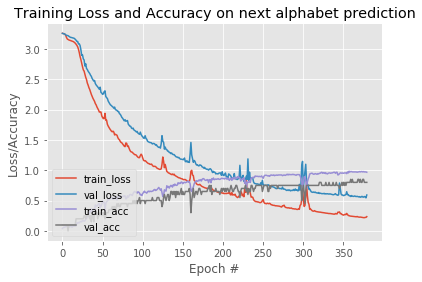

In [2]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochsVal
plt.plot(numpy.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(numpy.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(numpy.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(numpy.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on next alphabet prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")